<h1><center><font size="6">Santander EDA and Prediction</font></center></h1>

<h2><center><font size="4">Dataset used: Santander Customer Transaction Prediction</font></center></h2>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg" width="500"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check the data</a>   
 - <a href='#32'>Density plots of features</a>   
 - <a href='#33'>Distribution of mean and std</a>   
 - <a href='#34'>Distribution of min and max</a>   
  - <a href='#35'>Distribution of skew and kurtosis</a>   
 - <a href='#36'>Features correlations</a>   
 - <a href='#37'>Duplicate values</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.  

The data is anonimyzed, each row containing 200 numerical values identified just with a number.  

In the following we will explore the data, prepare it for a model, train a model and predict the target value for the test set, then prepare a submission.

Stay tuned, I will frequently update this Kernel in the next days.



# <a id='2'>Prepare for data analysis</a>  


## Load packages


In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Load data   

Let's check what data files are available.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/Santander/"
else:
    PATH="../input/"
os.listdir(PATH)

['sample_submission.csv', 'test.csv', 'train.csv']

Let's load the train and test data files.

In [3]:
%%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

CPU times: user 16.2 s, sys: 1.35 s, total: 17.6 s
Wall time: 17.6 s


# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [4]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

Both train and test data have 200,000 entries and 202, respectivelly 201 columns. 

Let's glimpse train and test dataset.

In [ ]:
train_df.head()

In [ ]:
test_df.head()

Train contains:  

* **ID_code** (string);  
* **target**;  
* **200** numerical variables, named from **var_0** to **var_199**;

Test contains:  

* **ID_code** (string);  
* **200** numerical variables, named from **var_0** to **var_199**;


Let's check if there are any missing data. We will also chech the type of data.

We check first train.

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
%%time
missing_data(train_df)

Here we check test dataset.

In [ ]:
%%time
missing_data(test_df)

There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [ ]:
%%time
train_df.describe()

In [ ]:
%time
test_df.describe()

We can make few observations here:   

* standard deviation is relatively large for both train and test variable data;  
* min, max, mean, sdt values for train and test data looks quite close;  
* mean values are distributed over a large range.

The number of values in train and test set is the same. Let's plot the scatter plot for train and test set for few of the features.


In [ ]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

We will show just 5% of the data. On x axis we show train values and on the y axis we show the test values.

In [5]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

NameError: name 'plot_feature_scatter' is not defined

Let's check the distribution of **target** value in train dataset.

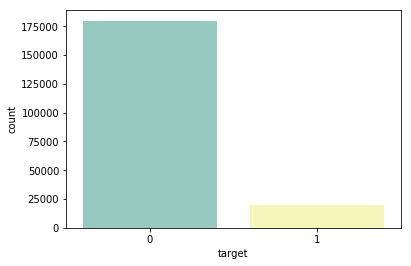

In [7]:
sns.countplot(train_df['target'], palette='Set3')

In [8]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


The data is unbalanced with respect with **target** value.   


## <a id='32'>Density plots of features</a>  

Let's show now the density plot of variables in train dataset. 

We represent with different colors the distribution for values with **target** value **0** and **1**.

In [11]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

The first 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

<Figure size 432x288 with 0 Axes>

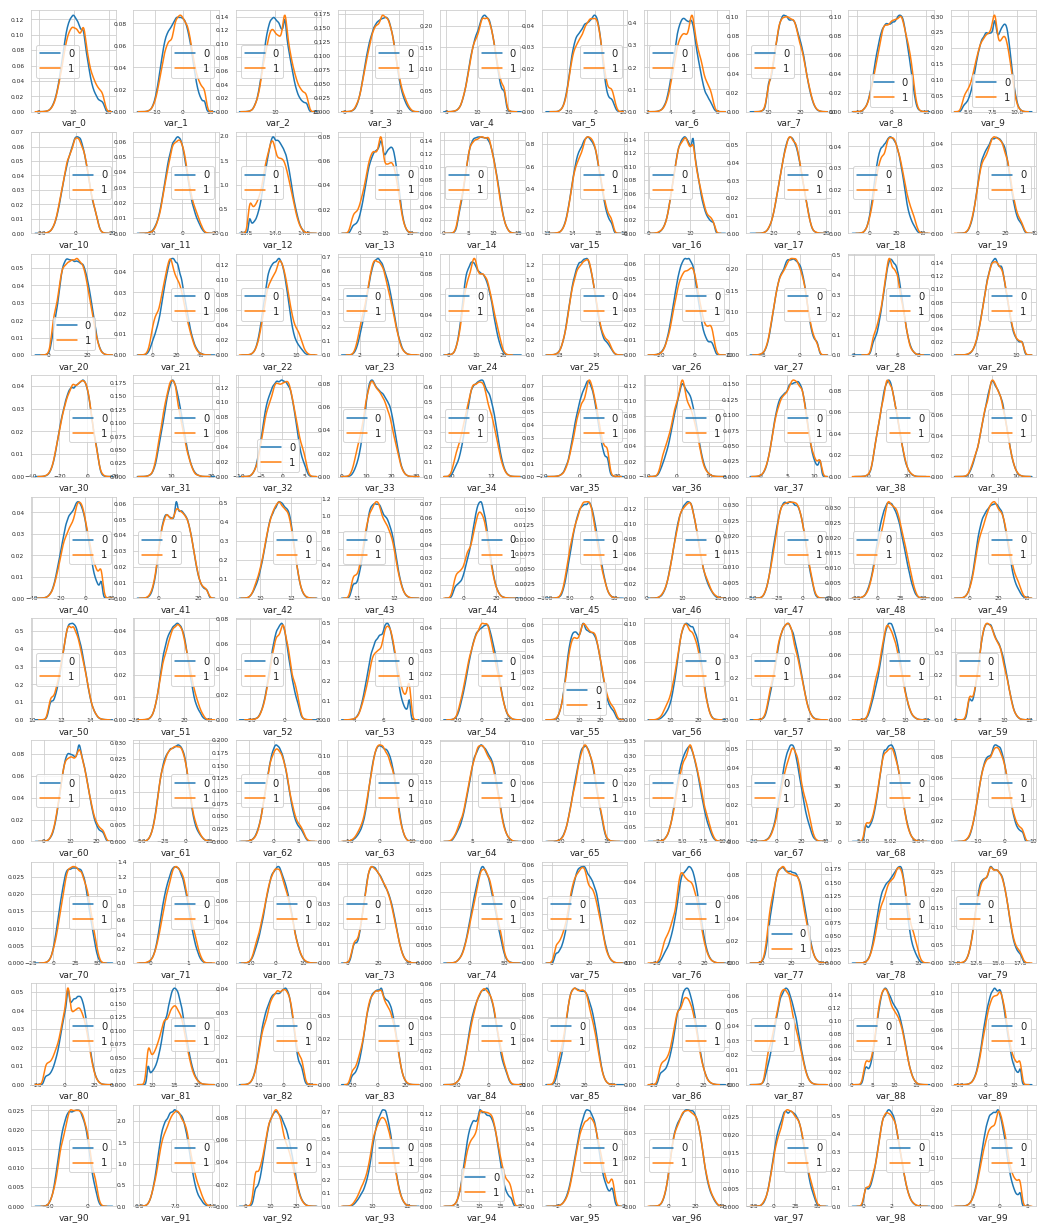

In [12]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

The next 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

We can observe that there is a considerable number of features with significant different distribution for the two target values.  
For example, **var_0**, **var_1**, **var_2**, **var_5**, **var_9**, **var_13**, **var_106**, **var_109**, **var_139** and many others.

Also some features, like **var_2**, **var_13**, **var_26**, **var_55**, **var_175**, **var_184**, **var_196** shows a distribution that resambles to a bivariate distribution.

We will take this into consideration in the future for the selection of the features for our prediction model.  

Le't s now look to the distribution of the same features in parallel in train and test datasets. 

The first 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

In [ ]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

The next 100 values are displayed in the following cell. Press <font color='red'>**Output**</font> to display the plots.

In [ ]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

The train and test seems to be well ballanced with respect with distribution of the numeric variables.  

## <a id='33'>Distribution of mean and std</a>  

Let's check the distribution of the mean values per row in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check the distribution of the mean values per columns in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show the distribution of standard deviation of values per row for train and test datasets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

Let's check the distribution of the standard deviation of values per columns in the train and test datasets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## <a id='34'>Distribution of min and max</a>  

Let's check the distribution of min per row in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

A long queue to the lower values for both, extended as long as to -80 for test set, is observed.

Let's now show the distribution of min per column in the train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check now the distribution of max values per rows for train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show now the max distribution on columns for train and test set.

In [ ]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1).

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

We show here the distribution of min values per columns in train set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show now the distribution of max values per rown in the train set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## <a id='35'>Distribution of skew and kurtosis</a>  

Let's see now what is the distribution of skew values per rows and columns.

Let's see first the distribution of skewness calculated per rows in train and test sets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's see first the distribution of skewness calculated per columns in train and test set.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's see now what is the distribution of kurtosis values per rows and columns.

Let's see first the distribution of kurtosis calculated per rows in train and test sets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's see first the distribution of kurtosis calculated per columns in train and test sets.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's see now the distribution of skewness on rows in train separated for values of target 0 and 1.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of skewness on columns in train separated for values of target 0 and 1.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of kurtosis on rows in train separated for values of target 0 and 1.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of kurtosis on columns in train separated for values of target 0 and 1.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## <a id='36'>Features correlation</a>  

We calculate now the correlations between the features in train set.  
The following table shows the first 10 the least correlated features.

In [ ]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Let's look to the top most correlated features, besides the same feature pairs.

In [ ]:
correlations.tail(10)

Let's see also the least correlated features.

In [ ]:
correlations.head(10)

The correlation between the features is very small. 

## <a id='37'>Duplicate values</a>  

Let's now check how many duplicate values exists per columns.

In [ ]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Let's show the top 15 max of duplicate values per train set.

In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

Let's see also the top 15 number of duplicates values per test set.

In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

# <a id='4'>Feature engineering</a>  

This section is under construction.  

Let's calculate for starting few aggregated values for the existing features.

In [ ]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

Let's check the new created features.

In [ ]:
train_df[train_df.columns[202:]].head()

In [ ]:
test_df[test_df.columns[201:]].head()

In [ ]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

Let's check the distribution of these new, engineered features.  

We plot first the distribution of new features, grouped by value of corresponding `target` values.

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Let's show the distribution of new features values for train and test.

In [ ]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

We add rounded features.  
**Note**: this is a work in progress, some of the features added here will be later dropped.

<code>
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
for feature in features:
    train_df['r2_'+feature] = np.round(train_df[feature], 2)
    test_df['r2_'+feature] = np.round(test_df[feature], 2)
    train_df['r1_'+feature] = np.round(train_df[feature], 1)
    test_df['r1_'+feature] = np.round(test_df[feature], 1)
</code>

Let's check how many features we have now.

In [ ]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

# <a id='5'>Model</a>  

From the train columns list, we drop the ID and target to form the features list.

In [ ]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

We define the hyperparameters for the model.

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

We run the model.

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Let's check the feature importance.

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

# <a id='6'>Submission</a>  

We submit the solution.

In [ ]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

# <a id='7'>References</a>    

[1] https://www.kaggle.com/gpreda/elo-world-high-score-without-blending  
[2] https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897  
[3] https://www.kaggle.com/brandenkmurray/nothing-works

